In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Solamente para usuarios de Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [2]:

from get_images import get_images

In [3]:
# MNIST path
mnist_path = './mnist_raw/'

x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)
x_test_num.shape


(10000, 28, 28)

In [4]:

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)/255
y_test = y_test_num.copy().reshape(10000, 1)

/tmp/ipykernel_13351/1748610980.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)/255
/tmp/ipykernel_13351/1748610980.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)/255


In [5]:
print(x_train.shape) #shape (50000, 784)
print(y_train.shape) #shape (50000, 1)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


In [6]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 8


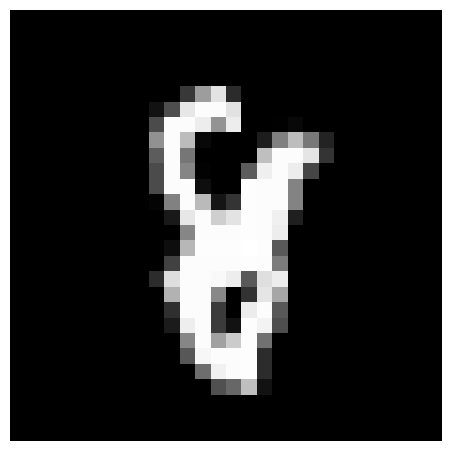

In [7]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx][0]}')
plot_number(x_test_num[rnd_idx])

In [8]:
x_train.shape[0]


50000

In [9]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

Init parameters

In [10]:
def init_parameters(input_size: int, neurons: list) -> dict:
    '''
    input_size -> elemntos de entrada, 784,
    neurons -> list [200, 10] cib cabtudad de neuronas
    
    '''
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2':b2}

In [71]:
parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)

(200, 784)
(10, 200)
(10, 1)


In [72]:
def relu(x):
    return np.maximum(0, x)

In [73]:
def scores(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [74]:
z2, z1, a1 = scores(x_train[:64].T, parameters, relu) 

In [75]:
z2.shape

(10, 64)

In [76]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

In [77]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

In [78]:
def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads
    

In [79]:
y_hat, cost = x_entropy(z2, y_train[:64])

In [80]:
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        lenght = len(x)
        z2, z1, a1 = scores(x.T, parameters, relu)
        y_hat, cost = x_entropy(z2, y, batch_size=lenght)
        
        correct +=   np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [81]:
def train(epochs, parameters, mb_size=64, learning_rate=1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            lenght = len(x)
            z2, z1, a1 = scores(x.T, parameters, relu)
            y_hat, cost = x_entropy(z2, y, batch_size=lenght)
            grads = backward(y_hat, x, y, z1, a1, z2, parameters, batch_size=lenght)
            
            parameters['W1'] -= learning_rate*grads['w1']
            parameters['b1'] -= learning_rate*grads['b1']
            parameters['W2'] -= learning_rate*grads['W2']
            parameters['b2'] -= learning_rate*grads['b2']
            
        print(f'El costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')        
    return parameters
    

In [82]:
mb_size = 512
learning_rate = 1e-2
epochs = 20

parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)



El costo es: 0.521179898573355, y accuracy: 0.8628
El costo es: 0.36588087761861454, y accuracy: 0.9043
El costo es: 0.26600978940505604, y accuracy: 0.9173
El costo es: 0.25462169722356215, y accuracy: 0.9225
El costo es: 0.2979129056715169, y accuracy: 0.9278
El costo es: 0.30893722973935456, y accuracy: 0.9341
El costo es: 0.2418333381477519, y accuracy: 0.9397
El costo es: 0.21139272161657927, y accuracy: 0.9456
El costo es: 0.13628754122081135, y accuracy: 0.9491
El costo es: 0.18915406322167155, y accuracy: 0.9531
El costo es: 0.1274807063614062, y accuracy: 0.955
El costo es: 0.15150952551774485, y accuracy: 0.9568
El costo es: 0.1540528943580299, y accuracy: 0.9585
El costo es: 0.15378771524562332, y accuracy: 0.9588
El costo es: 0.15925515278924657, y accuracy: 0.9608
El costo es: 0.20047932471911425, y accuracy: 0.9615
El costo es: 0.1493208243808935, y accuracy: 0.9639
El costo es: 0.18598670796558464, y accuracy: 0.9643
El costo es: 0.09412290078345656, y accuracy: 0.9658
E

In [83]:
accuracy(x_test, y_test, mb_size)

0.9658

In [87]:
def predict(x):
    scores2, _, _ = scores(x, parameters, relu)
    return np.argmax(scores2)

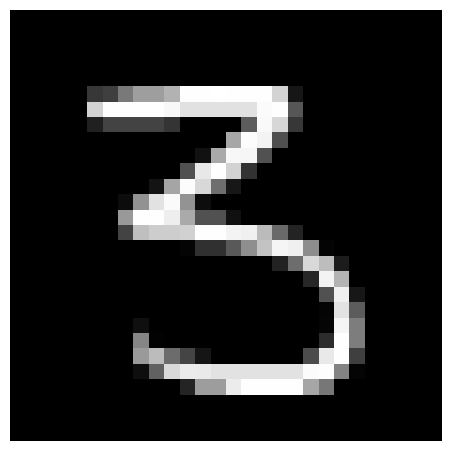

El valor predicho es: 3


In [154]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'El valor predicho es: {pred}')